# Transfer Learning with TensorFlow Part 1: Feature Extraction

**Transfer Learning** - taking the patterns (also called weights) another model has learned from another problem and using them for our own problem

Benefits:
- Leverage an existing neural network architecture proven to work on problems similar to our own.
- Leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.

Contents to cover:
- Introduce transfer learning (a way to beat all of our old self-built models)
- Using a smaller dataset to experiment faster (10% of training samples of 10 classes of food)
- Build a transfer learning feature extraction model using TensorFlow Hub
- Introduce the TensorBoard callback to track model training results
- Compare model results using TensorBoard

#Transfer Learning with TensorFlow Hub: Getting great results with less data

TensorFlow Hub is repository for existing model components

Going to use only 10% of data to show how transfer learning can perform better than our old model using less data

# Downloading and becoming one with data

In [1]:
# Getting 10% of data

import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-02-05 23:33:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.8MB/s    in 7.9s    

2023-02-05 23:34:01 (20.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
# Checking file structure 

import os

# Walk through directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent

Training directory has less images than before (75 vs 750 images)

Test diretory has same amount of images (250 images). 

Training on less data but evaluating on same amount of test data

# Preparing the data

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE  = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Training Images: ')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')

print('Testing Images: ')
test_data = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical')

Training Images: 
Found 750 images belonging to 10 classes.
Testing Images: 
Found 2500 images belonging to 10 classes.


# Setting up callbacks (things to run while model trains)

callbacks - extra functionalities added to models to be performed during or after training. Popular callbacks include:
- Experiment tracking with TensorBoard - log performances of multiple models to be compared in a visual way. Helpful to compare results
- Model checkpointing - save model as it trains incase you need to stop training and come back to continue later. Helpful if training takes a long time or cannot be done in one sitting
- Early stopping - leave model training for some time and automatically stop training when it ceases to improve. Helpful if unsure how long training will take

Create a function that creates a TensorBoard callback 

In [19]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Creating models using TensorFlow Hub

Going to use two models from [TensorFlow Hub](https://tfhub.dev/):

[ResNetV2](https://arxiv.org/abs/1603.05027) - a state of the art computer vision model architecture from 2016.

[EfficientNet](https://arxiv.org/abs/1905.11946) - a state of the art computer vision architecture from 2019.




1. "As is" transfer learning is when you take a pretrained model as it is and apply it to your task without any changes.

  - For example, many computer vision models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each class).

    - This is helpful if you have 1000 classes of image you'd like to classify and they're all the same as the ImageNet classes, however, it's not helpful if you want to classify only a small subset of classes (such as 10 different kinds of food). Model's with "/classification" in their name on TensorFlow Hub provide this kind of functionality.

2. Feature extraction transfer learning is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem.

  - For example, say the pretrained model you were using had 236 different layers (EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that only the top few layers become trainable, the rest remain frozen.

    - This way all the underlying patterns remain in the rest of the layers and you can utilise them for your own problem. This kind of transfer learning is very helpful when your data is similar to the data a model has been pretrained on.

3. Fine-tuning transfer learning is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem.

  - This usually means training some, many or all of the layers in the pretrained model. This is useful when you've got a large dataset (e.g. 100+ images per class) where your data is slightly different to the data the original model was trained on.



---

Import TensorFlow and TensorFlow Hub


In [20]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

Get the feature vector URLs of two common computer vision architectures, EfficientNetB0 (2019) and ResNetV250 (2016) from TensorFlow Hub

Getting both to compare which performs better on our data.

In [21]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

Comparing two different models so creating a function to take model from TensorFlow Hub URL and propulate with appropriate parameters

In [22]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

# Creating model using the ResNetV250 architecture

In [23]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

Add callback to track performance of model and fit model

In [24]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230206-002525
Epoch 1/5
24/24 [==============================] - 36s 1s/step - loss: 1.9782 - accuracy: 0.3373 - val_loss: 1.1926 - val_accuracy: 0.6300
Epoch 2/5
24/24 [==============================] - 15s 647ms/step - loss: 0.9185 - accuracy: 0.7253 - val_loss: 0.8566 - val_accuracy: 0.7252
Epoch 3/5
24/24 [==============================] - 15s 648ms/step - loss: 0.6401 - accuracy: 0.8227 - val_loss: 0.7617 - val_accuracy: 0.7560
Epoch 4/5
24/24 [==============================] - 15s 644ms/step - loss: 0.4926 - accuracy: 0.8760 - val_loss: 0.7096 - val_accuracy: 0.7736
Epoch 5/5
24/24 [==============================] - 15s 639ms/step - loss: 0.3888 - accuracy: 0.9147 - val_loss: 0.6778 - val_accuracy: 0.7716


ResNetV250 performs better than our model with about 90% accuracy on training set and 80% on test set using only 10% of training images

In [25]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

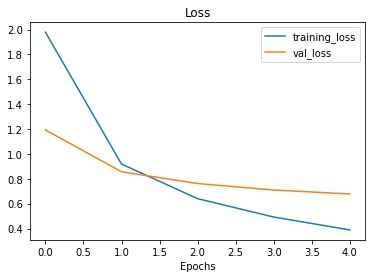

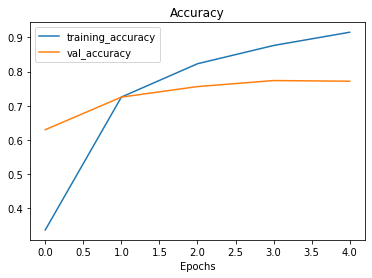

In [26]:
plot_loss_curves(resnet_history)

In [28]:
# ResNet summary 
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


# Creating model using the EfficientNetB0 architecture

In [29]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20230206-003205
Epoch 1/5
24/24 [==============================] - 31s 790ms/step - loss: 1.9164 - accuracy: 0.4093 - val_loss: 1.3441 - val_accuracy: 0.7100
Epoch 2/5
24/24 [==============================] - 16s 691ms/step - loss: 1.0730 - accuracy: 0.7733 - val_loss: 0.8803 - val_accuracy: 0.8124
Epoch 3/5
24/24 [==============================] - 14s 606ms/step - loss: 0.7565 - accuracy: 0.8293 - val_loss: 0.7024 - val_accuracy: 0.8420
Epoch 4/5
24/24 [==============================] - 14s 607ms/step - loss: 0.6042 - accuracy: 0.8693 - val_loss: 0.6127 - val_accuracy: 0.8564
Epoch 5/5
24/24 [==============================] - 14s 617ms/step - loss: 0.5102 - accuracy: 0.9013 - val_loss: 0.5554 - val_accuracy: 0.8656


EfficientNetB0 performs even better than ResNetV250! Improving upong the test accuracy to over 85%

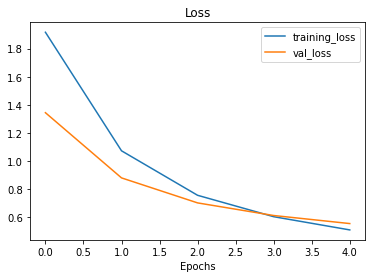

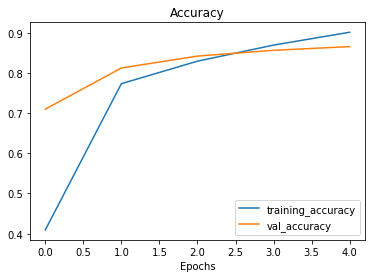

In [30]:
plot_loss_curves(efficientnet_history)

In [31]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


# Comparing models using TensorBoard

In [34]:
# Upload TensorBoard dev records

!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=MAqlByactH9pFhExkE5fr5YNMfF6sg&prompt=consent&access_type=off

Listing experiments you've saved to TensorBoard

In [35]:
# Check out experiments
!tensorboard dev list

https://tensorboard.dev/experiment/vtKYc33xT4WLQrlRXWd8XA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   vtKYc33xT4WLQrlRXWd8XA
	Created              2023-02-06 00:36:33 (55 seconds ago)
	Updated              2023-02-06 00:36:39 (49 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5921064
Total: 1 experiment(s)
